In [1]:
# Attempting to make predictions on the same mechanistic model but now using an LSTM and then hybridizing it

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import torchvision
import torchvision.transforms as tr
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import random
import math
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torch.optim as optim
import warnings
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
warnings.filterwarnings('ignore')

In [3]:
# Creating the Mechanistic Model
def odes(t, m):
    # X is biomass concentration
    # S is substarte concentration
    # V is volume 
    X, S, V = m
    # Declaring the constants
    k = 1
    
    # If time is lesser than 15
    if t < 15:
        # Flow Rate
        F = 1
        # Substrate Concentration coming in
        s0 = 60
      
    # If time is greater than 15
    else:
        F = 0
        s0 = 0
        

    #Declaring mu or growth rate equation
    mu = (5*S)/(10+S+(S**2)/0.1)
    # Declaring the differential equations
    
    # Change in biomass concentration with time
    dxdt = (mu*X) - X*(F/V)
    # Change in substarte concentration with time
    dsdt = -k*mu*X + (F/V)*(s0 - S)
    # Change in volume with time
    dvdt = F
    
    # Returning the above values to calculate the change at the next iteration or time point
    return [dxdt, dsdt, dvdt]

# Declaring the initial conditions of the model
# (Biomass Conc, Substrate Conc, Volume)
m0 = (5, 5, 10)

# Declaring a time vector
t = np.arange(0.0, 20.0, 0.2)

# Solving the differential equation using the odeint method
sol = odeint(odes, m0, t, tfirst = True)

In [4]:
# Extracting biomass conc, substrate conc and volume from the generated solution by
# transposing the matrix
X = sol.T[0]
S = sol.T[1]
V = sol.T[2]

# Computing the growth rate values
mu_list = []
for s in S:
    mu = 0
    mu = (1*s)/(1+s+(s**2)/1)
    mu_list.append(mu)

# Generating the dataset
mdf = pd.DataFrame()
mdf["Time"] = t
mdf["Biomass Concentration"] = X
mdf["Substrate Concentration"] = S
mdf["Volume"] = V
mdf["mu"] = mu_list
relu = nn.ReLU()
mdf_tensor = relu(torch.tensor(mdf.to_numpy(), dtype = torch.float32))
mdf = pd.DataFrame(mdf_tensor.numpy(), columns = ["Time", "Biomass Concentration", "Substrate Concentration","Volume", "mu"])
mu_list = mdf["mu"]
mdf

,Time,Biomass Concentration,Substrate Concentration,Volume,mu
0,0.000000,5.000000,5.000000,10.000000,0.161290
1,0.200000,4.987693,5.992699,10.200000,0.139673
2,0.400000,4.965100,6.957977,10.400000,0.123431
3,0.600000,4.935479,7.894710,10.600000,0.110848
4,0.800000,4.900981,8.802722,10.800000,0.100844
...,...,...,...,...,...
95,19.000000,3.010314,36.989689,25.000002,0.026304
96,19.200001,3.018436,36.981564,25.000002,0.026310
97,19.400000,3.026582,36.973419,25.000002,0.026315
98,19.600000,3.034751,36.965248,25.000002,0.026321


In [5]:
df = pd.DataFrame()
df["Time"] = t
list_b = []
list_s = []
for index in range(len(mdf)):
    if mdf.iloc[index].at["Biomass Concentration"] > 0:
        list_b.append(np.log(mdf.iloc[index].at["Biomass Concentration"]))
    else:
        list_b.append(0)
    
    if mdf.iloc[index].at["Substrate Concentration"] > 0:
        list_s.append(np.log(mdf.iloc[index].at["Substrate Concentration"]))
    else:
        list_s.append(0)
df["Biomass Concentration"] = list_b
df["Substrate Concentration"] = list_s
df["Volume"] = V
df["mu"] = mu_list

In [6]:
df

,Time,Biomass Concentration,Substrate Concentration,Volume,mu
0,0.0,1.609438,1.609438,10.000000,0.161290
1,0.2,1.606973,1.790542,10.200000,0.139673
2,0.4,1.602433,1.939889,10.400000,0.123431
3,0.6,1.596450,2.066193,10.600000,0.110848
4,0.8,1.589435,2.175061,10.800000,0.100844
...,...,...,...,...,...
95,19.0,1.102044,3.610639,25.000001,0.026304
96,19.2,1.104739,3.610420,25.000001,0.026310
97,19.4,1.107434,3.610199,25.000001,0.026315
98,19.6,1.110130,3.609978,25.000001,0.026321


In [7]:
from copy import deepcopy as dc
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    df.set_index('Time', inplace=True)
    for i in range(1, n_steps+1):
        df[f'S(t-{i})'] = df['Substrate Concentration'].shift(i)
    for i in range(1, n_steps+1):
        df[f'X(t-{i})'] = df['Biomass Concentration'].shift(i)
    df.dropna(inplace=True)
    return df

lookback = 6
df = prepare_dataframe_for_lstm(df, lookback)
df

,Biomass Concentration,Substrate Concentration,Volume,mu,S(t-1),S(t-2),S(t-3),S(t-4),S(t-5),S(t-6),X(t-1),X(t-2),X(t-3),X(t-4),X(t-5),X(t-6)
Time,,,,,,,,,,,,,,,,
1.2,1.573359,2.354639,11.200000,0.085990,2.270307,2.175061,2.066193,1.939889,1.790542,1.609438,1.581672,1.589435,1.596450,1.602433,1.606973,1.609438
1.4,1.564640,2.430046,11.400000,0.080338,2.354639,2.270307,2.175061,2.066193,1.939889,1.790542,1.573359,1.581672,1.589435,1.596450,1.602433,1.606973
1.6,1.555622,2.498030,11.600000,0.075524,2.430046,2.354639,2.270307,2.175061,2.066193,1.939889,1.564640,1.573359,1.581672,1.589435,1.596450,1.602433
1.8,1.546387,2.559754,11.800000,0.071378,2.498030,2.430046,2.354639,2.270307,2.175061,2.066193,1.555622,1.564640,1.573359,1.581672,1.589435,1.596450
2.0,1.536998,2.616134,12.000000,0.067770,2.559754,2.498030,2.430046,2.354639,2.270307,2.175061,1.546387,1.555622,1.564640,1.573359,1.581672,1.589435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19.0,1.102044,3.610639,25.000001,0.026304,3.610858,3.611076,3.611294,3.611511,3.611727,3.611942,1.099350,1.096657,1.093964,1.091272,1.088581,1.085890
19.2,1.104739,3.610420,25.000001,0.026310,3.610639,3.610858,3.611076,3.611294,3.611511,3.611727,1.102044,1.099350,1.096657,1.093964,1.091272,1.088581
19.4,1.107434,3.610199,25.000001,0.026315,3.610420,3.610639,3.610858,3.611076,3.611294,3.611511,1.104739,1.102044,1.099350,1.096657,1.093964,1.091272


In [8]:
# Lets start implementing the neural network model using pytorch

# Defining the hyperparameters
input_size = 2
hidden_layer_size = 50
output_size = 1
learning_rate = 000.1
batch_size = 8
num_epochs = 300

# Define early stopping criteria
patience = 20  # Number of epochs without improvement before stopping
min_delta = 0.000000000025  # Minimum improvement in the validation loss

# Initialize variables for early stopping
best_val_loss = float('inf')
epochs_without_improvement = 0

In [9]:
train, test = train_test_split(df)
new_train, validation_set = train_test_split(train, test_size = 0.2)

In [10]:
class PandasDataset(Dataset):
    def __init__(self, dataframe):
        # This converts the dataframe passed into a numpy array and then into a pytorch tensor
        self.dataframe = torch.tensor(dataframe.values)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        return self.dataframe[index]

In [11]:
train_wrapped = PandasDataset(new_train)
validation_wrapped = PandasDataset(validation_set)
train_loader = torch.utils.data.DataLoader(dataset=train_wrapped.dataframe, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_wrapped.dataframe, batch_size=7, shuffle=True)

In [12]:
# THIS NEEDS TO BE CONVERTED TO AN LSTM

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(NeuralNet, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        hidden_states = torch.zeros(self.num_layers, x.shape[0], self.hidden_size)
        cell_states = torch.zeros(self.num_layers, x.shape[0], self.hidden_size)
        out, _ = self.lstm(x, (hidden_states, cell_states))
        out = self.output_layer(out[:, -1, :])
        return out

In [13]:
model = NeuralNet(2, 30, 1, 3)

In [14]:
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 20, factor = 0.65, eps = 1e-8, verbose = True,
                                                #threshold = 1e-6)

In [15]:
# this is the training loop
loss_curve = []
val_curve = []
best_loss = 1000000.0
best_weights = None

for epoch in range(num_epochs):
    losses = []
    for i, (data) in enumerate(train_loader):
        
        # Prepocessing the data
        input_data = data[:, 4:].to(torch.float32)
        input_data = input_data.reshape(8, 6, 2)
        target_output = (data[:, 3].to(torch.float32)).view(8, 1)
        
        # Forward pass
        predictions = model(input_data)
        l = loss(predictions, target_output)
        losses.append(l)
        
        # Bacward Pass
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    
    model.eval()
    # Calculate and log the training loss
    mean_loss = sum(losses)/len(losses)
    loss_curve.append(mean_loss)
    writer.add_scalar('Loss/Train', mean_loss, epoch)
    #scheduler.step(mean_loss)
    
    if mean_loss.item() < best_loss:
        best_loss = mean_loss.item()
        best_weights = model.state_dict()

    val_loss = 0.0
    with torch.no_grad():
        for i, (data) in enumerate(validation_loader):
            inputs = data[:, 4:].to(torch.float32)
            inputs = inputs.reshape(7, 6, 2)
            target = (data[:, 3].to(torch.float32)).view(7, 1)
            outputs = model(inputs)
            lo = loss(outputs, target)
            val_loss += lo.item()
    val_loss /= len(validation_set)
    
    val_curve.append(val_loss)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    # Check for improvement
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    
    # Early stopping condition
    if epochs_without_improvement >= patience:
        break

    print("Epoch: {}, Validation Loss: {:.8f}".format(epoch, val_loss))
 
    with torch.no_grad():
        if epoch % 10 == 0:
            print(f'epoch {epoch} = loss: {mean_loss}')

# Restore the model to the best weights
model.load_state_dict(best_weights)

Epoch: 0, Validation Loss: 0.00073569
epoch 0 = loss: 1.8703439235687256
Epoch: 1, Validation Loss: 0.00005392
Epoch: 2, Validation Loss: 0.00027966
Epoch: 3, Validation Loss: 0.00015243
Epoch: 4, Validation Loss: 0.00005446
Epoch: 5, Validation Loss: 0.00006568
Epoch: 6, Validation Loss: 0.00003061
Epoch: 7, Validation Loss: 0.00000526
Epoch: 8, Validation Loss: 0.00000470
Epoch: 9, Validation Loss: 0.00001011
Epoch: 10, Validation Loss: 0.00000766
epoch 10 = loss: 2.800462425511796e-05
Epoch: 11, Validation Loss: 0.00000529
Epoch: 12, Validation Loss: 0.00000118
Epoch: 13, Validation Loss: 0.00000819
Epoch: 14, Validation Loss: 0.00001436
Epoch: 15, Validation Loss: 0.00000792
Epoch: 16, Validation Loss: 0.00000492
Epoch: 17, Validation Loss: 0.00000211
Epoch: 18, Validation Loss: 0.00000803
Epoch: 19, Validation Loss: 0.00000208
Epoch: 20, Validation Loss: 0.00000531
epoch 20 = loss: 2.9107990485499613e-05
Epoch: 21, Validation Loss: 0.00003019
Epoch: 22, Validation Loss: 0.00001828

<All keys matched successfully>

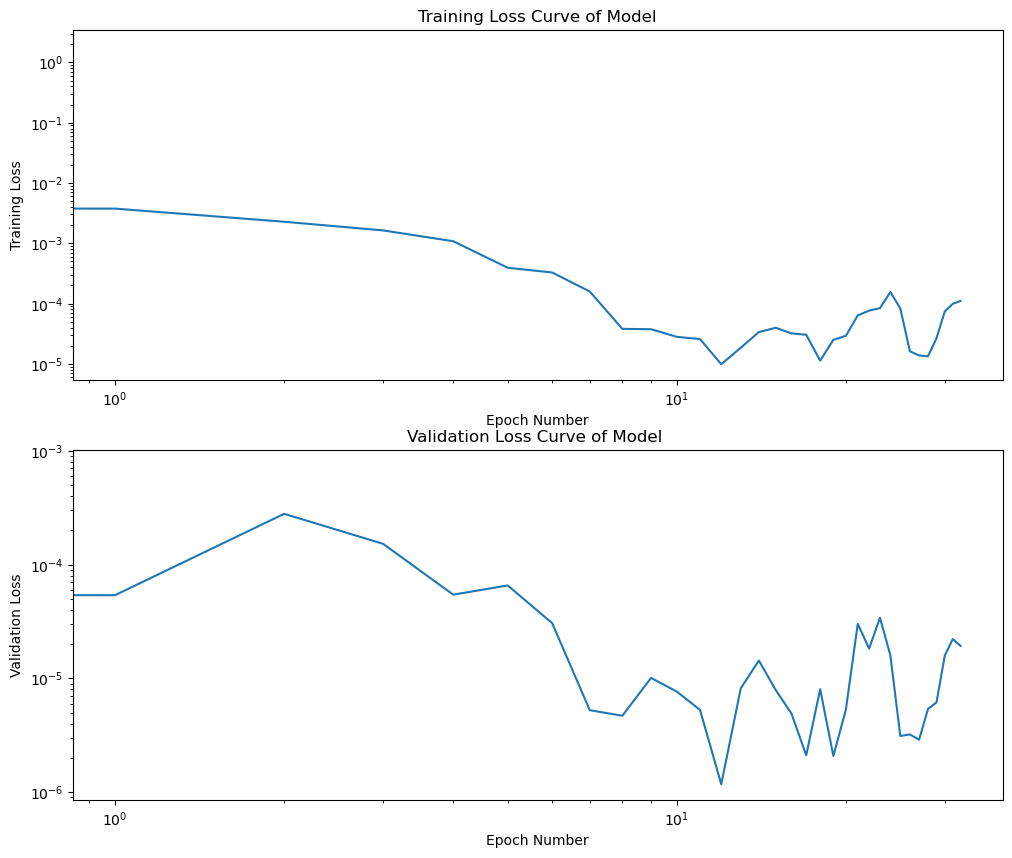

In [16]:
with torch.no_grad():
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    ax1.plot(loss_curve)
    ax1.set_title("Training Loss Curve of Model")
    ax1.set_xlabel("Epoch Number")
    ax1.set_ylabel("Training Loss")
    ax2.plot(val_curve)
    ax2.set_title("Validation Loss Curve of Model ")
    ax2.set_xlabel("Epoch Number")
    ax2.set_ylabel("Validation Loss")
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_yscale('log')

In [17]:
df_input_features = df[['S(t-1)', 'S(t-2)', 'S(t-3)', 'S(t-4)', 'S(t-5)','S(t-6)', 
                        'X(t-1)', 'X(t-2)', 'X(t-3)', 'X(t-4)', 'X(t-5)','X(t-6)']].values
df_input_tensor = torch.tensor(df_input_features, dtype=torch.float32)
with torch.no_grad():
    df_predictions_list = []
    for row in df_input_tensor:
        row = row.reshape(1, 6, 2)
        df_predictions = model(row)
        df_predictions_list.append(df_predictions)

In [18]:
df_predictions_list

[tensor([[0.0871]]),
 tensor([[0.0835]]),
 tensor([[0.0805]]),
 tensor([[0.0778]]),
 tensor([[0.0755]]),
 tensor([[0.0734]]),
 tensor([[0.0714]]),
 tensor([[0.0697]]),
 tensor([[0.0681]]),
 tensor([[0.0666]]),
 tensor([[0.0653]]),
 tensor([[0.0640]]),
 tensor([[0.0628]]),
 tensor([[0.0617]]),
 tensor([[0.0607]]),
 tensor([[0.0597]]),
 tensor([[0.0588]]),
 tensor([[0.0579]]),
 tensor([[0.0571]]),
 tensor([[0.0563]]),
 tensor([[0.0555]]),
 tensor([[0.0548]]),
 tensor([[0.0541]]),
 tensor([[0.0534]]),
 tensor([[0.0528]]),
 tensor([[0.0522]]),
 tensor([[0.0516]]),
 tensor([[0.0510]]),
 tensor([[0.0505]]),
 tensor([[0.0500]]),
 tensor([[0.0495]]),
 tensor([[0.0490]]),
 tensor([[0.0485]]),
 tensor([[0.0480]]),
 tensor([[0.0476]]),
 tensor([[0.0471]]),
 tensor([[0.0467]]),
 tensor([[0.0463]]),
 tensor([[0.0459]]),
 tensor([[0.0455]]),
 tensor([[0.0452]]),
 tensor([[0.0448]]),
 tensor([[0.0444]]),
 tensor([[0.0441]]),
 tensor([[0.0438]]),
 tensor([[0.0434]]),
 tensor([[0.0431]]),
 tensor([[0.0

Text(0, 0.5, 'Growth Rate (mu)')

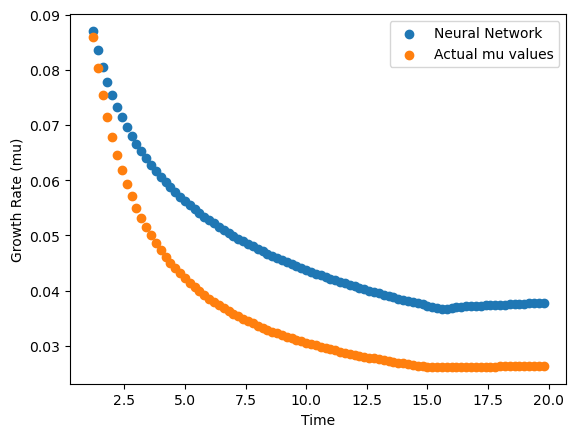

In [19]:
plt.scatter(df.index, df_predictions_list, label = "Neural Network")
plt.scatter(df.index, df["mu"], label = "Actual mu values")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Growth Rate (mu)")

In [20]:
df_test_input = test[['S(t-1)', 'S(t-2)', 'S(t-3)', 'S(t-4)', 'S(t-5)','S(t-6)',
                     'X(t-1)', 'X(t-2)', 'X(t-3)', 'X(t-4)', 'X(t-5)','X(t-6)']].values
df_input_tensor = torch.tensor(df_test_input, dtype=torch.float32)
with torch.no_grad():
    df_predictions_list = []
    for row in df_input_tensor:
        row = row.reshape(1, 6, 2)
        df_predictions = model(row)
        df_predictions_list.append(df_predictions)

Text(0, 0.5, 'Growth Rate (mu)')

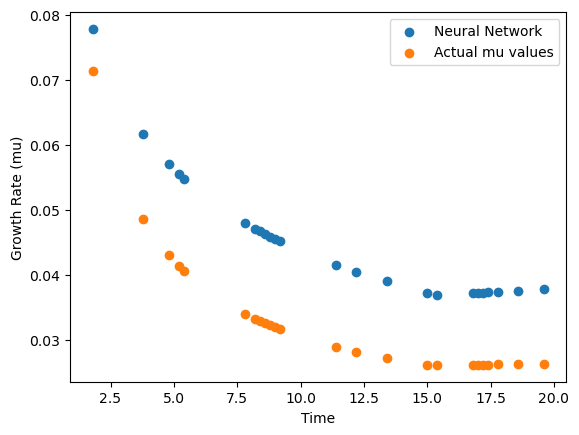

In [21]:
plt.scatter(test.index, df_predictions_list, label = "Neural Network")
plt.scatter(test.index, test["mu"], label = "Actual mu values")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Growth Rate (mu)")

In [22]:
type(loss)

torch.nn.modules.loss.MSELoss